#### Investigating disconnect in TC tracking and pairing with GCM data
This script is an exercise to figure out why a TC tracking algorithm fails to capture TC properties in a GCM.
The specific issue occurs in the HIRAM control configuration with constant SSTs.

In [1]:
''' Import packages. '''
import matplotlib.pyplot as plt, numpy as np, os, pandas as pd, random, sys, xarray as xr

sys.path.insert(1, '/projects/GEOCLIM/gr7610/scripts')

### Reproduce the problem

In [174]:
model_name_TC = 'AM2.5'
experiment_name_TC = 'CTL1990.0N'
dirname_TC = '/tigress/GEOCLIM/gr7610/analysis/TC-AQP/data/individual_TCs'
filenames_TC = [f for f in os.listdir(dirname_TC)
                if model_name_TC in f
                and experiment_name_TC in f]
SINGLE_TC = xr.open_dataset(os.path.join(dirname_TC, random.choice(filenames_TC))).sortby('time')

# Get time index corresponding to lifetime maximum intensity
get_LMI_index = lambda x: x['min_slp'].argmin()
LMI_index = get_LMI_index(SINGLE_TC)

Text(0.0, 1.0, 'Storm ID: 0008-0069\nTimestamp: 0008-12-18 06:00:00')

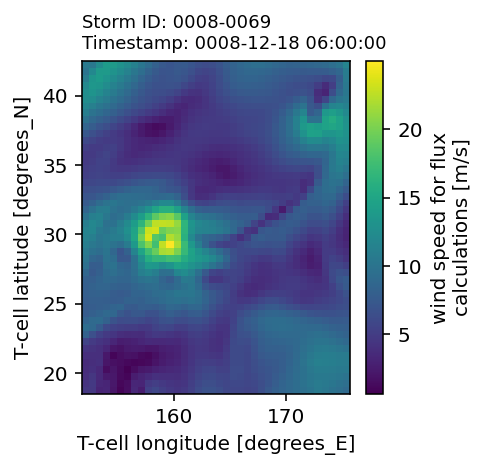

In [175]:
field_name = 'wind'
timestamp = SINGLE_TC['time'].isel(time=LMI_index).item()

fig, ax = plt.subplots(figsize=(3, 3), dpi=144)
SINGLE_TC[field_name].isel(time=LMI_index).dropna(dim='grid_xt', how='all').dropna(dim='grid_yt', how='all').plot(ax=ax)
ax.set_title('') # remove the xarray-generated title
ax.set_title(f'Storm ID: {SINGLE_TC.attrs['storm_id']}\nTimestamp: {timestamp}', fontsize=9, ha='left', loc='left')

### Troubleshooting

#### Track data

In [33]:
# Load track data for year 2 in HIRAM constant-SST configuration
import tc_analysis, track_TC_GCM

if 'track_data' not in locals():
    track_data = tc_analysis.tc_track_data(models=['HIRAM'], 
                                           experiments=['CTL1990.CONST'], 
                                           year_range=(2, 3), 
                                           storm_type='TS',
                                           parallel_load=False,
                                           diagnostic=False)['HIRAM']['CTL1990.CONST']['raw']

# Get the raw track data from a case study TC
case_TC = track_data.loc[track_data['storm_id'] == SINGLE_TC.attrs['storm_id']]

Text(0.0, 1.0, 'Storm ID: 0002-0325; min. SLP: 923.96 hPa\nTimestamp: 0002-07-05 18:00:00')

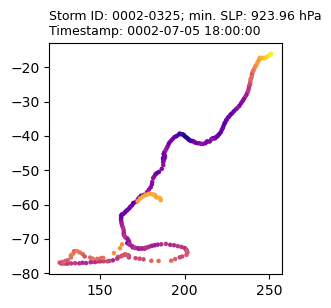

In [34]:
# Plot track and intensity data
fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(case_TC['center_lon'], case_TC['center_lat'], s=5, c=case_TC['min_slp'], cmap='plasma')
ax.set_title(f'Storm ID: {SINGLE_TC.attrs['storm_id']}; min. SLP: {case_TC['min_slp'].min():.2f} hPa\nTimestamp: {timestamp}', fontsize=9, ha='left', loc='left')

#### GCM data

In [35]:
pathname = '/scratch/gpfs/GEOCLIM/gr7610/tiger3/HIRAM/work/CTL1990.CONST_tiger3_intelmpi_24_540PE/POSTP/00020101.atmos_4xdaily.nc'
case_GCM = xr.open_dataset(pathname)[['slp', 'WVP']]

In [36]:
case_LMI_index = get_LMI_index(case_TC)
case_timestamp = case_TC['cftime'].iloc[case_LMI_index]
case_snapshot_lon, case_snapshot_lat = [case_TC.loc[case_TC['cftime'] == case_timestamp]['center_lon'].values[0],
                                        case_TC.loc[case_TC['cftime'] == case_timestamp]['center_lat'].values[0]]
case_GCM_snapshot = case_GCM.sel(time=case_timestamp).sel(grid_xt=slice(case_snapshot_lon - 20, case_snapshot_lon + 20),
                                                          grid_yt=slice(case_snapshot_lat - 20, case_snapshot_lat + 20)).load()

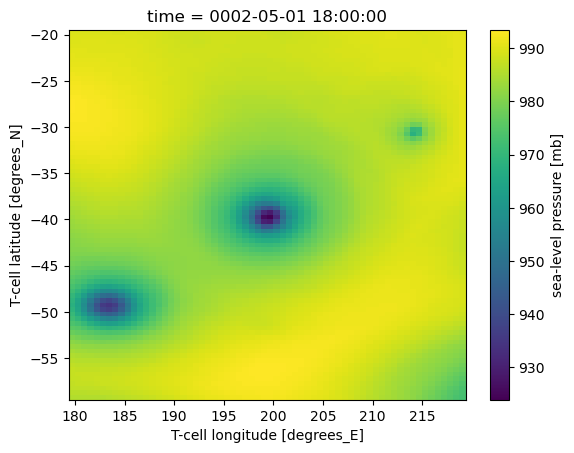

In [37]:
case_GCM_snapshot['slp'].plot()